In [131]:
import os
import re
from itertools import chain, combinations
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sklearn
import utils
from geopandas.datasets import get_path
from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from ydata_profiling import ProfileReport

In [132]:
pd.options.mode.chained_assignment = None

main_path = Path.cwd() / ".."
df = pd.read_csv(main_path / "data/weatherAUS.csv")

In [133]:
spectral_palette = [
    "#9e0142",
    "#d53e4f",
    "#f46d43",
    "#fdae61",
    "#fee08b",
    "#ffffbf",
    "#e6f598",
    "#abdda4",
    "#66c2a5",
    "#3288bd",
    "#5e4fa2",
]

In [134]:
# ProfileReport(df) # Uncomment for a preview of the dataframe

---

##### Inspección general de las columnas del dataframe

FEATURES
- Date: La fecha de la observación
- Location: Ubicación de la estación meteorológica
- MinTemp: Temperatura mínima en grados celsius
- MaxTemp: Temperatura máxima en grados celsius
- Rainfall: Cantidad de agua de lluvia para el día en mm
- Evaporation: Evaporación registrada para el día en mm
- Sunshine: Cantidad de horas de luz solar para el día
- WindGustDir: Dirección de la ráfaga de viento más intensa
- WindGustSpeed: Velocidad de la ráfaga de viento más intensa
- WindDir9am: Dirección del viento a las 9 am
- WindDir3pm: Dirección del viento a las 3 pm
- WindSpeed9am: Velocidad del viento a las 9 am
- WindSpeed3pm: Velocidad del viento a las 3 pm
- Humidity9am: Porcentaje de humedad a las 9 am
- Humidity3pm: Porcentaje de humedad a las 3 pm
- Pressure9am: Presión atmosférica a las 9 am en hectopascales
- Pressure3pm: Presión atmosférica a las 3 pm en hectopascales
- Cloud9am: Fracción del cielo cubierto a las 9 am en oktas
- Cloud3pm: Fracción del cielo cubierto a las 3 pm en oktas
- Temp9am: Temperatura a las 9 am en grados celsius
- Temp3pm: Temperatura a las 3 pm en grados celsius
- RainToday: Indicador binario acerca de si hay lluvia el día observado

TARGET
- RainTomorrow: Indicador binario acerca de si hay lluvia al día siguiente

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [136]:
df = df.sort_values(by=["Location", "Date"]).reset_index(drop=True)

is_any_duplicated = df.duplicated(subset=["Date", "Location"], keep=False).any()
print("Observaciones duplicadas para una fecha o localidad: ", is_any_duplicated)

Observaciones duplicadas para una fecha o localidad:  False


_Encontramos que la mayoria de las columnas corresponden a variables cuantitativas. Podemos observar que cuatro de ellas poseen una gran proporción de valores nulos: "Evaporation", "Sunshine", "Cloud9am", "Cloud3pm". El resto de las variables numéricas poseen cerca del 10% de valores faltantes o menos._

_Entre las variables de tipo cualitativas identificamos a "Location" y "Date" como columnas identificatorias de una observación, es decir, no hay filas con valores repetidos si tomamos el subset de esas dos columnas. Tampoco se observan valores nulos en niguna de ambas columnas. La importancia de estas variables no reside sólo en su carácter identificatorio, sino además proveen información, espacial y temporal, que vamos a procesar más adelante y que puede resultar útil para nuestro modelo._

_Observamos además que, entre las variables de tipo cualitativa tenemos la variable target "RainTomorrow", binaria por definición del problema a resolver, y la variable "RainToday" que, intuitivamente, sigue una misma codificación que la variable target mencionada. Es importante notar que ambas variables binarias cuentan con valores nulos en algunas observaciones._

_Finalmente, encontramos tres variables cualitativas relacionadas con la dirección del viento en diferentes momentos del día. Podemos considerar a estas variables como categóricas ordinales en el sistema de coordenadas polares, no existiendo relación de menor-mayor entre ellas pero si una relación secuencial en dos dimensiones._

In [137]:
# Create lists of columns based on their dtype
num_columns = df.select_dtypes(include='number').columns.tolist()
cat_columns = ["WindGustDir", "WindDir9am", "WindDir3pm"]

---

##### Inspección variables binarias: "RainToday" y "RainTomorrow"

In [138]:
columns = ["RainToday", "RainTomorrow"]
for column in columns:
    print(df[column].value_counts())
    utils.print_missing_perc(df, column)
    print()

RainToday
No     110319
Yes     31880
Name: count, dtype: int64
Porcentaje de valores faltantes en la columna RainToday: 2.2%

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64
Porcentaje de valores faltantes en la columna RainTomorrow: 2.2%



_Se observa que la distribución de los valores que asumen las columnas son muy similares, lo cual tiene sentido debido a que el dataset elegido es una serie temporal y el valor de RainTomorrow en una observación es el valor de RainToday para el día siguiente._

_Encontramos además la misma proporción de valores nulos en ambas columnas._

Mapeamos las variables binarias a {0, 1} representando la ausencia o presencia de lluvia en el día o el día siguiente según la columna.

In [139]:
mapping_dict = {"Yes" : 1, "No" : 0}
df["RainToday"] = df["RainToday"].map(mapping_dict)
df["RainTomorrow"] = df["RainTomorrow"].map(mapping_dict)

A modo de baseline inicial para nuestro trabajo realizamos un modelo simple que predice lluvia para el día siguiente si el día de la observación también llovió, y evaluamos los resultados obtenidos.

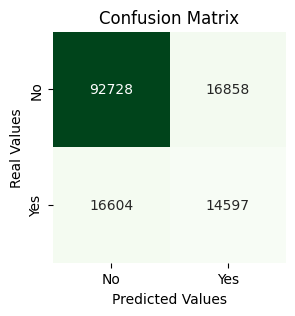

Accuracy: 0.76
Precision: 0.46
Recall: 0.47
F1 Score: 0.47


In [140]:
filt = (df["RainToday"].isna()) | (df["RainTomorrow"].isna())

utils.evaluate_predictions(df.loc[~filt, "RainTomorrow"], df.loc[~filt, "RainToday"])

In [141]:
confusion_matrix = pd.crosstab(df["RainToday"], df["RainTomorrow"])
phi, p = utils.phi_coefficient(confusion_matrix)

print(f"Phi Coefficient: {phi}")
print(f"p-value: {p}")

Phi Coefficient: 0.31307621724262796
p-value: 0.0


_Observamos que el valor de accuracy se encuentra inflado por el desbalanceo en el dataset. De hecho, si predijeramos siempre ausencia de lluvia obtendríamos un valor de 0.78 en esa métrica. Claro que en ese caso obtendríamos un valor de 0 para precision y recall._

_Con este modelo inicial planteado obtenemos un F1 score de 0.47, con valores para precision y recall muy similares._

_Calculando el coeficiente Phi entre ambas variables binarias encontramos un valor de 0.3 (asociación entre variables moderada y positiva) con una significancia que nos permite rechazar la hipóteses de que la asociación encontrada puede deberse simplemente a la variabilidad de el muestreo aleatorio._

---

##### Inspección variables identificatorias: "Date", "Location"

In [142]:
# Convert date to datetime for further processing
df["Date"] = pd.to_datetime(df["Date"])

Para evaluar la coherencia interna del dataset verificamos que no haya observaciones con valor nulo en RainTomorrow, teniendo la observación del día siguiente con valor existente en la columna RainToday, para una misma estación meteorológica.

In [143]:
diff_one_day = df["Date"].shift(-1) - df["Date"] == pd.Timedelta("1 day")
same_location = df["Location"] == df["Location"].shift(-1)
na_today_value_tomorrow = df["RainTomorrow"].isna() & ~(df["RainToday"].shift(-1).isna())

filt = diff_one_day & same_location & na_today_value_tomorrow
assert df.loc[filt, :].shape[0] == 0

Graficamos las observaciones diarias en función de la estación meteorológica para ver con que registros contamos.

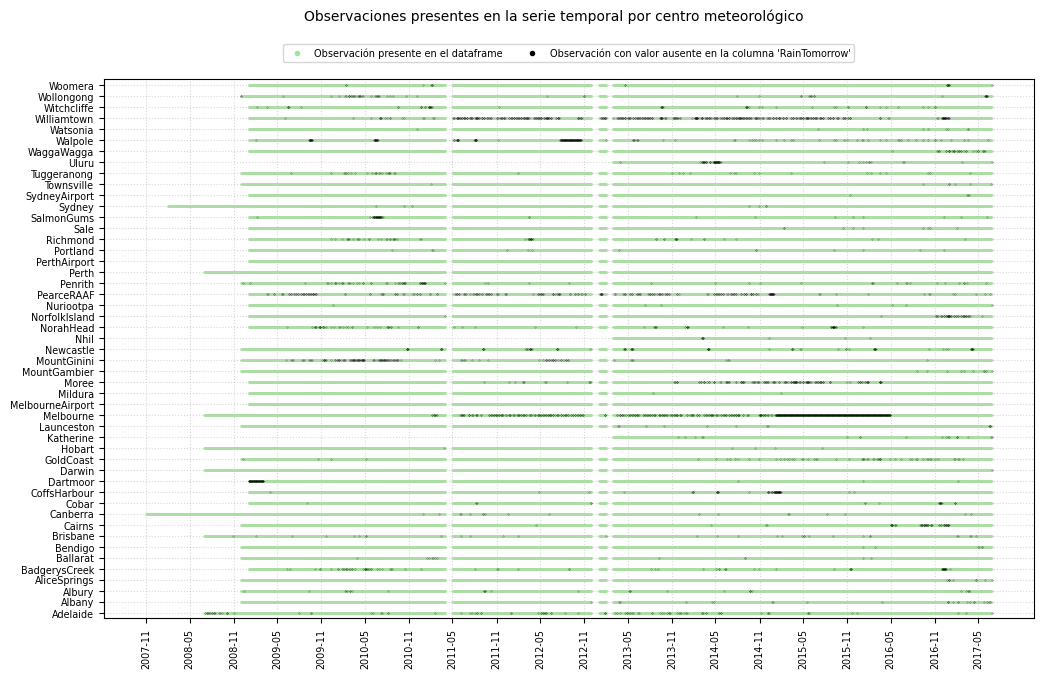

In [144]:
# Call the function to create the plot
utils.plot_locations_over_time(df, color=spectral_palette[7])

_Se observa que tenemos observaciones faltantes correspondientes a meses enteros para todas las estaciones meteorológicas. Además podemos observar que el inicio de la serie temporal para cada una de ellas difiere, siendo la observación más antigua de noviembre 2007._

_Encontramos que en algunas de las localidades contamos con mayor cantidad de valores nulos en la columna target "RainTomorrow". A priori esperábamos encontrar que los valores nulos para esa variable se encontraran dónde la serie temporal se corta, sin embargo podemos ver que aparecen aleatoriamente a lo largo de la serie temporal, y que en algunas locaciones incluso tenemos datos válidos en la variable "RainTomorrow" a pesar de no contar con una observación para el día siguiente al registrado._

_Las estaciones con mayor cantidad de datos faltantes en la variable target son Melbourne y Wiliamtown. En lo que a Melbourne concierne, podemos observar que hay registros también en el aeropuerto de esa ciudad, por lo que podemos inferir que los patrones cimáticos de una de esas estaciones puede brindar información de utilidad para predecir si llueve al día siguiente en la otra. Extendiendo a todas las estaciones meteorológicas entendemos que incorporar la posición geográfica puede resultar de gran utilidad para el desarrollo de nuestro modelo predictivo._

Geolocalizamos las estaciones meteorológicas utilizando el servicio Open Street Map para obtener la posición geográfica de cada una de ellas.

In [145]:
country = "Australia"

world = gpd.read_file(get_path('naturalearth_lowres'))
gdf_australia = world[world.name == country]

# Solve manually some mistaken names
mapping_dict = {"Dartmoor": "DartmoorVillage", "Richmond": "RichmondSydney"}
df["Location"] = df["Location"].map(mapping_dict).fillna(df["Location"])

locations = df["Location"].unique()
locations = [re.sub(r'([a-z])([A-Z])', r'\1 \2', l) for l in locations]

locs = []
lats = []
lons = []
for location in locations:
    try:
        lat, lon = ox.geocode(location + f", {country}")

        locs.append(location.replace(" ", ""))
        lats.append(lat)
        lons.append(lon)
    except Exception as e:
        print(f"Error retrieving coordinates for {location}: {e}")

df_locations = pd.DataFrame({
    'Location': locs,
    'Lat': lats,
    'Lon': lons
})
geometry = [Point(lon, lat) for lon, lat in zip(df_locations['Lon'], df_locations['Lat'])]
gdf_locations = gpd.GeoDataFrame(df_locations, geometry=geometry, crs="EPSG:4326")

C:\Users\usuario\AppData\Local\Temp\ipykernel_3720\499948971.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(get_path('naturalearth_lowres'))


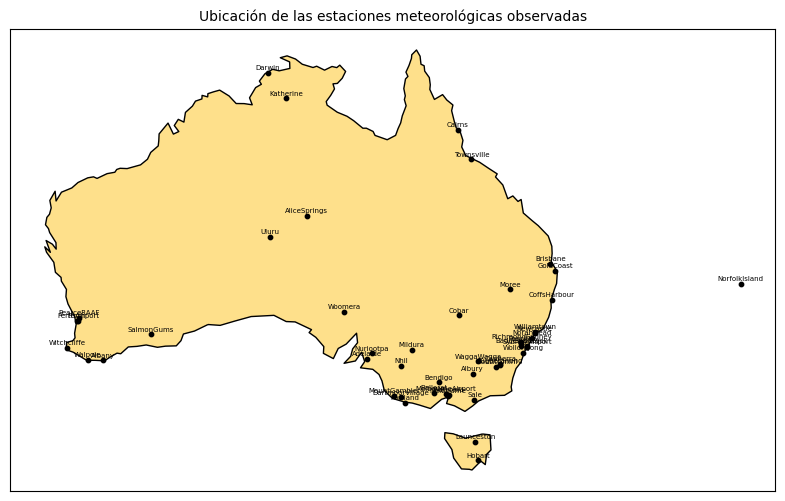

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))
gdf_australia.plot(ax=ax, edgecolor='k', facecolor=spectral_palette[4])

# Plot locations
gdf_locations.plot(ax=ax, marker='o', color='black', markersize=10, label='Locations')

for idx, row in gdf_locations.iterrows():
    ax.text(
        row['geometry'].x,
        row['geometry'].y + .2,
        row['Location'],
        fontsize=5,
        ha='center',
        va='bottom'
        )

ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal', adjustable='box')

plt.title(
        "Ubicación de las estaciones meteorológicas observadas",
        fontsize=10,
    )

plt.show()

_Podemos ver una gran cantidad de estaciones meteorológicas concentradas en la costa sureste de Australia, y en menor medida en la costa suroeste. Además notamos que algunas de las estaciones se encuentran muy cercanas entre si, lo cual puede traer aparejado una correlación entre los patrones climáticos._

Analizamos el coeficiente Phi para la variable "RainToday" comparando entre pares de estaciones meteorológicas y cruzando con la información de la distancia euclideana entre ellas.

In [147]:
locations = df["Location"].unique()
location_pairs = list(combinations(locations, 2))

df_location_pairs = pd.DataFrame(location_pairs, columns=['LocationA', 'LocationB'])
df_location_pairs['phi'] = np.nan
df_location_pairs['pvalue'] = np.nan

for index, row in df_location_pairs.iterrows():
    loc1, loc2 = row['LocationA'], row['LocationB']
    df_pair = df[df['Location'].isin([loc1, loc2])]
    df_pivot = df_pair.pivot(index='Date', columns='Location', values='RainToday').dropna()
    
    if not df_pivot.empty:
        confusion_matrix = pd.crosstab(df_pivot[loc1], df_pivot[loc2])
        phi, pvalue = utils.phi_coefficient(confusion_matrix.values)
        df_location_pairs.at[index, 'phi'] = phi
        df_location_pairs.at[index, 'pvalue'] = pvalue

In [148]:
df_location_a = df_location_pairs[["LocationA"]].merge(
    gdf_locations[["Location", "geometry"]],
    how="left",
    left_on="LocationA",
    right_on="Location",
)
gdf_location_a = gpd.GeoDataFrame(df_location_a, geometry="geometry")
gdf_location_a_gda94 = gdf_location_a.to_crs(epsg=3112)

df_location_b = df_location_pairs[["LocationB"]].merge(
    gdf_locations[["Location", "geometry"]],
    how="left",
    left_on="LocationB",
    right_on="Location",
)
gdf_location_b = gpd.GeoDataFrame(df_location_b, geometry="geometry")
gdf_location_b_gda94 = gdf_location_b.to_crs(epsg=3112)

distance_ab = gdf_location_a_gda94["geometry"].distance(gdf_location_b_gda94["geometry"])

df_location_pairs["distance"] = distance_ab / 1000 # distance in kilometers

In [149]:
df_location_pairs.sort_values(by="phi", ascending=False).head(10)

,LocationA,LocationB,phi,pvalue,distance
1023,Perth,PerthAirport,0.868273,0.000000e+00,10.170125
1110,Sydney,SydneyAirport,0.834880,0.000000e+00,9.159054
426,Canberra,Tuggeranong,0.834520,0.000000e+00,13.690617
988,PearceRAAF,PerthAirport,0.811493,0.000000e+00,29.675737
1008,Penrith,RichmondSydney,0.794405,0.000000e+00,17.339476
987,PearceRAAF,Perth,0.776889,0.000000e+00,34.306090
519,DartmoorVillage,MountGambier,0.776575,0.000000e+00,45.125869
211,BadgerysCreek,Penrith,0.774937,0.000000e+00,15.112316
736,Melbourne,Watsonia,0.759375,2.271215e-283,15.719700
215,BadgerysCreek,RichmondSydney,0.740126,0.000000e+00,30.966137


_Observamos que, tal como intuíamos, las estaciones con mayor coeficiente Phi tienen entre si para la variable RainToday, son aquellos que se encuentran cerca geográficamente._

Vamos a gráficar la relación entre la distancia geográfica y la correlación calculada mediante el coeficiente Phi para todos los pares de estaciones meteorológicas en el dataset.

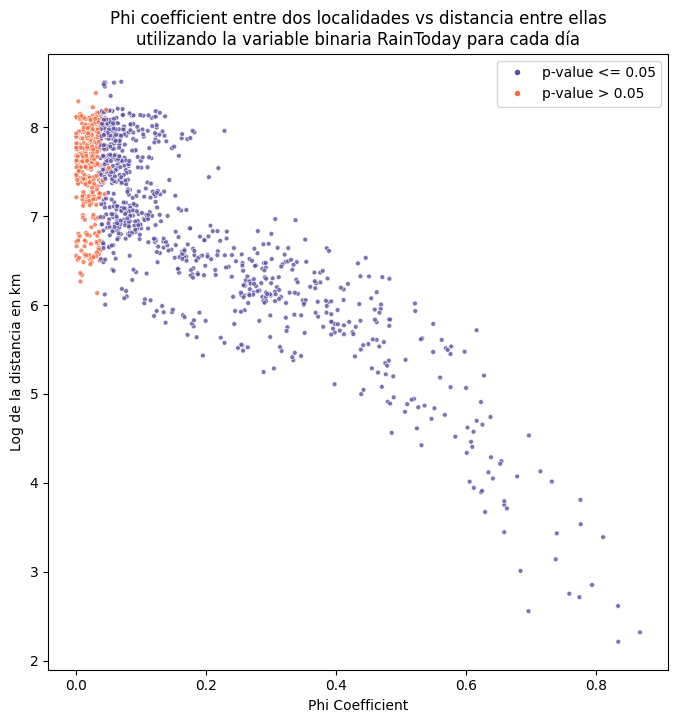

In [150]:
plt.figure(figsize=(8, 8))

df_location_pairs["significant"] = df_location_pairs['pvalue'] <= .05
colors = [spectral_palette[10] if sig else spectral_palette[2] for sig in df_location_pairs['significant']]

sc = plt.scatter(df_location_pairs['phi'], np.log(df_location_pairs['distance']), 
                 s=12, c=colors, alpha=.8, edgecolors='w', linewidth=0.5)

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=spectral_palette[10], markersize=5, label='p-value <= 0.05'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=spectral_palette[2], markersize=5, label='p-value > 0.05')
])

plt.xlabel('Phi Coefficient')
plt.ylabel('Log de la distancia en km')
plt.title('Phi coefficient entre dos localidades vs distancia entre ellas\nutilizando la variable binaria RainToday para cada día')

plt.show()

_Efectivamente, encontramos una importante correlación visual entre ambas variables graficadas: la distancia y la correlación para la variable RainToday para cada par de estaciones._

_Esta situación resulta interesante en cuanto refuerza nuestra hipótesis de que la codificación espacial de las estaciones meteorológicas resulta informativa para un modelo encargado de predecir lluvia para el día siguiente._

_Además, entendemos que debemos de estar atentos al momento de dividir nuestro dataset para entrenamiento y testeo del mismo. Si entrenamos nuestro modelo con datos de un día específico en estaciones meteorológicas cercanas entre si, y luego lo testeamos con una observación del mismo día pero de otra estación también cercana, corremos el riesgo de que el modelo aprenda que en esa zona geográfica llovió al día siguiente en lugar de realmente realizar una predicción desconociendo el futuro. Por esto consideramos que nuestro set de testeo y validación debe comprender un periodo de tiempo definido e incluir a todas las estaciones para ese período._

---

---
Las primeras columnas que vamos a evaluar van a ser Rain Today y Rain Tomorrow. Establecemos un baseline para el resto del análisis.

---

Acá podemos hacer un análisis de las columnas antes de incorporar la variable de localización. Ver que correlación hay a priori entre las variables principales.

In [151]:
# # Analisis de variables categóricas
# # 1
# "RainToday" # Target del día anterior
# "RainTomorrow" # Target

# # 2
# "Date" # Análisis realizado de datos faltantes
# "Location"

#3 Ver que valores únicos hay. Verificar que no haya valores nulos. COnvertir a formato numérico de dirección 2d
cat_columns = ["WindGustDir", "WindDir9am", "WindDir3pm"]
df_cat = df[cat_columns]

uniques_dirs = set(chain.from_iterable(df_cat[column].unique() for column in cat_columns))
print("Valores tipo string en las columnas categoricas: ", ' - '.join(d for d in uniques_dirs if isinstance(d, str)))
print("Otros valores en las columnas categoricas: ",' - '.join(str(d) for d in uniques_dirs if not isinstance(d, str)))

Valores tipo string en las columnas categoricas:  WNW - SSE - SE - W - NE - S - NNE - NNW - E - NW - ESE - WSW - SSW - N - SW - ENE
Otros valores en las columnas categoricas:  nan


Se observan 16 categorías, cada una de ellas representando una dirección posible del viento con una resolución de 22.5°. Vamos a transformar la dirección del viento a grados considerando la dirección 'E' como nuestro 0° (y por lo tanto también nuestro 360°). Este método nos permitirá ordenar los valores para poder analizar graficamente la relación entre las variables.

In [152]:
dirs = ["E", "ENE", "NE", "NNE", "N", "NNW", "NW", "WNW", "W", "WSW", "SW", "SSW", "S", "SSE", "SE", "ESE"]
angles = list(np.arange(0, 360, 22.5))
mapping_dict = {d: a for (d, a) in zip(dirs, angles)}

df_cat = df_cat.map(lambda x: mapping_dict.get(x, x))

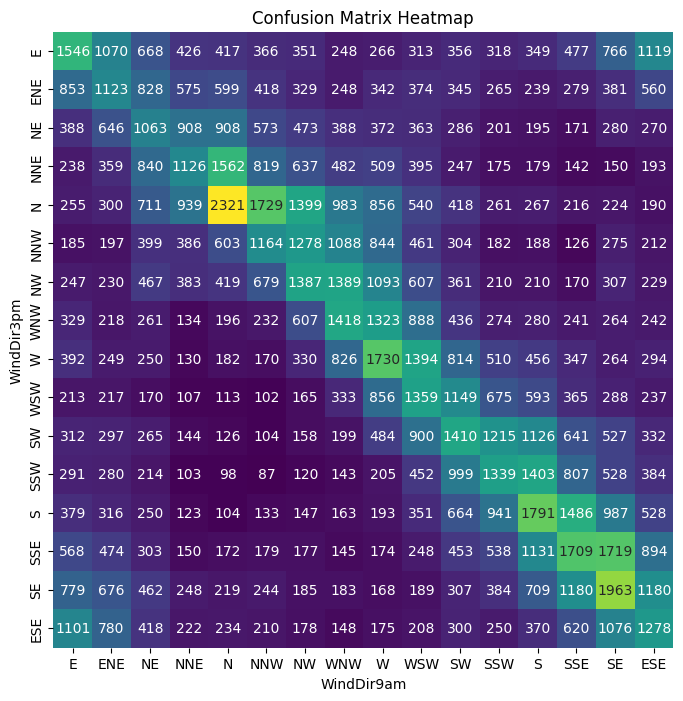

In [153]:
confusion_matrix = pd.crosstab(df_cat["WindDir9am"], df_cat["WindDir3pm"])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=dirs, yticklabels=dirs, cbar=False)
plt.xlabel('WindDir9am')
plt.ylabel('WindDir3pm')
plt.title('Confusion Matrix Heatmap')
plt.show()

Se observa una estrecha relación visual entre la dirección del viento registrada a las 9am y la dirección del viento registrada a las 3pm. Debido a la condición circular de las posibles direcciones que el viento puede tomar, aparecen valores altos en las esquinas inferior izquierda y superior derecha del gráfico.

---

Lo que podemos hacer es incorporar la información de la variable geomgráfica y ver la correlación cruzada con la distancia para una variable para diferentes localizaciones.

Primero geolocalizamos.

Observamos que algunas de las estaciones meteorológicas se encuentran muy cercanas entre si. Intuitivamente podemos inferir que estaciones más cercanas poseerán una mayor correlación entre sus valores para diferentes variables. Esto puede ser interesante al momento de imputar datos faltantes!!!

---

In [154]:
def count_nas_per_location(df, column):
    df = df.copy()

    df[column] = df[column].isna().map(
        {True:"is_na", False:"not_na"}
        )

    count_valid = df.groupby(["Location", column]).size().reset_index(name="count")
    count_valid = pd.pivot(count_valid, index="Location", columns=column, values="count")

    count_valid["na_perc"] = (
        count_valid[f"is_na"] / (count_valid[f"not_na"] + count_valid[f"is_na"])
    ).round(3)

    return count_valid.sort_values(by="na_perc", ascending=False)

In [155]:
count_nas_per_location(df, "Cloud9am").head(5)

Cloud9am,is_na,not_na,na_perc
Location,,,
RichmondSydney,2404.0,605.0,0.799
Uluru,1230.0,348.0,0.779
Launceston,2315.0,725.0,0.762
Albury,1751.0,1289.0,0.576
Wollongong,1695.0,1345.0,0.558


---

A partir del análisis realizado hasta el momento encontramos las siguientes variables categóricas a codificar:

- "Date"
- "Location"
- "WindGustDir", "WindDir9am", "WindDir3pm"
- "RainToday" y "RainTomorrow" (codificada a indicador binario en el apartado anterior)

##### Variable "Date"

Cada observación se registra con el día, mes y año. Sin embargo, tratar estos componentes como características independientes presenta varios inconvenientes:

Días del mes:
- La representación numérica entera de los días no refleja la condición circular de anterioridad de los días altos de un mes respecto a los bajos del siguiente. Además, los meses tienen diferentes números de días por lo que aun si el modelo logra capturar esa circularidad, puede ser dificultoso entender que la distancia entre un determinado número de día y otro no es siempre la misma (ej. entre el 28 de un mes y el 1 del siguiente puede haber 1 o 4 días).
- El valor numérico del día en un mes no informa directamente sobre la probabilidad de lluvia para el día siguiente.

Meses:
- Tienen una moderadamente alta cardinalidad para ser representados mediante one-hot encoding. pAdemás, esta técnica otorga la misma distancia euclideana a cada par de vectores que representan cada uno de los 12 meses.
- Si se usan valores enteros del 1 al 12, se pierde la circularidad, complicando la interpretación de la distancia temporal entre los útlimos meses y los primeros.

Años:
- Son informativos para variaciones climáticas anuales, pero pueden introducir problemas al generalizar a datos de años no vistos durante el entrenamiento.

Por estas razones, codificamos la fecha como el número de día del año, utilizando coordenadas polares para reflejar su estructura circular. De este modo se traduce la información brindada por la fecha a su ubicación dentro de un año calendario, codificandola en dos nuevas variables.


In [156]:
def plot_day_of_year_in_unit_circle():
    # Create a DataFrame to hold the values
    days = np.arange(1, 366, 2)
    days_in_year = 366

    angles = 2 * np.pi * (days - 1) / days_in_year
    cos_vals = np.cos(angles)
    sin_vals = np.sin(angles)

    df_days = pd.DataFrame({
        'Day': days,
        'Angle': angles,
        'DayCos': cos_vals,
        'DaySin': sin_vals
    })

    # Randomly select a day
    random_day = 37
    random_day_row = df_days[df_days['Day'] == random_day]

    # Plot the circle with 365 dots
    plt.figure(figsize=(5, 5))
    plt.plot(df_days['DayCos'], df_days['DaySin'], 'bo', markersize=1)  # Circle with 365 dots

    # Highlight the random day
    plt.plot(random_day_row['DayCos'], random_day_row['DaySin'], 'ro', markersize=2)
    plt.text(random_day_row['DayCos'].values[0] + 0.02, random_day_row['DaySin'].values[0], 
            f"Day {random_day}\n({random_day_row['DayCos'].values[0]:.2f},{random_day_row['DaySin'].values[0]:.2f})",
            fontsize=6, ha='left', va='bottom')

    # Draw x and y axes
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)

    # Draw the angle
    plt.plot([0, 1], [0, 0], 'k-', linewidth=1)
    plt.plot([0, random_day_row['DayCos'].values[0]], [0, random_day_row['DaySin'].values[0]], 'k-', linewidth=1)

    angle_text = f"{np.degrees(random_day_row['Angle'].values[0]):.2f}°"
    label_angle = random_day_row['Angle'].values[0] / 4
    plt.text(0.3 * np.cos(label_angle) + 0.05, 0.3 * np.sin(label_angle) + 0.05, angle_text, color='k', fontsize=8, ha='center', va='center')

    # Mark and label the cosine value on the axes
    plt.plot([random_day_row['DayCos'].values[0], random_day_row['DayCos'].values[0]], [0, random_day_row['DaySin'].values[0]], 'k--', linewidth=0.4)
    plt.text(random_day_row['DayCos'].values[0], -0.05, 
            f"{random_day_row['DayCos'].values[0]:.2f}", 
            fontsize=7, 
            ha='center', 
            va='top')

    plt.plot([0, random_day_row['DayCos'].values[0]], [random_day_row['DaySin'].values[0], random_day_row['DaySin'].values[0]], 'k--', linewidth=0.4)
    plt.text(-0.05, random_day_row['DaySin'].values[0], 
            f"{random_day_row['DaySin'].values[0]:.2f}",  
            fontsize=7, 
            ha='right', 
            va='center')

    # Set equal aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

    # Labels and title
    plt.xlabel('DayCos')
    plt.ylabel('DaySin')
    plt.title('Representación del día del año en coordenadas polares', fontsize=10)

    plt.tick_params(axis='both', labelsize=6)

    plt.show()

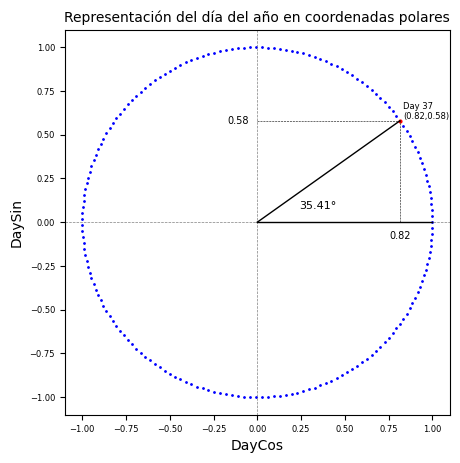

In [157]:
plot_day_of_year_in_unit_circle()

_Codificar la fecha de esta manera cuenta con la ventaja de que indirectamente estamos incorporando la información de las estaciones del año, ya que para valores positivos de CosDay y SinDay nos encontramos con días de verano mientras que para valores negativos de ambos lo hacemos con días de invierno. En la diagonal opuesta sucede algo similar con días de primavera y otoño._

In [158]:
df['DayOfYear'] = df['Date'].dt.dayofyear

# Determine the number of days in the year for each date (taking leap years into account)
df['DaysInYear'] = df['Date'].dt.is_leap_year.apply(lambda leap: 366 if leap else 365)

# Convert day of the year to angle in radians, dividing by DaysInYear + 1
df['Angle'] = 2 * np.pi * (df['DayOfYear'] - 1) / (df['DaysInYear'])

df['DayCos'] = np.cos(df['Angle'])
df['DaySin'] = np.sin(df['Angle'])

df = df.drop(columns=["DayOfYear", "DaysInYear", "Angle"])

Vamos a entrenar un modelo de Regresión Logística utilizando únicamente las columnas creadas como features para predecir la variable objetivo "RainTomorrow". Vamos a comparar los resultados obtenidos mediante esa codificación con la codificación ordinal del día y el mes para examinar el desempeño de la técnica utilizada.

In [159]:
# Initialize lists to store results
random_states = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
polar_results = []
integer_results = []

# Methodology 1: DayCos, DaySin
df_model_cos_sin = df[["DayCos", "DaySin", "RainTomorrow"]]
df_model_cos_sin = df_model_cos_sin.dropna(how='any').reset_index(drop=True)

# Methodology 2: Day, Month
df_model_day_month = df[["Date", "RainTomorrow"]]
df_model_day_month["Day"] = df_model_day_month["Date"].dt.day
df_model_day_month["Month"] = df_model_day_month["Date"].dt.month
df_model_day_month = pd.get_dummies(df_model_day_month, columns=["Month"], drop_first=True, dtype=int)
df_model_day_month = df_model_day_month.drop(columns="Date")
df_model_day_month = df_model_day_month.dropna(how='any').reset_index(drop=True)

for random_state in random_states:
    # Methodology 1: DayCos, DaySin
    X1 = df_model_cos_sin.drop(columns="RainTomorrow")
    y1 = df_model_cos_sin["RainTomorrow"]
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=random_state)

    model1 = LogisticRegression(class_weight='balanced')
    model1.fit(X1_train, y1_train)
    y1_pred = model1.predict(X1_test)

    acc1 = accuracy_score(y1_test, y1_pred)
    f1_1 = f1_score(y1_test, y1_pred)

    polar_results.append({
        'RandomState': random_state,
        'PolarAccuracy': round(acc1, 3),
        'PolarF1': round(f1_1, 3)
    })

    # Methodology 2: Day, Month
    X2 = df_model_day_month.drop(columns="RainTomorrow")
    y2 = df_model_day_month["RainTomorrow"]
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=random_state)

    scaler = StandardScaler()
    X2_train_scaled = scaler.fit_transform(X2_train)
    X2_test_scaled = scaler.transform(X2_test)

    model2 = LogisticRegression(class_weight='balanced')
    model2.fit(X2_train_scaled, y2_train)
    y2_pred = model2.predict(X2_test_scaled)

    acc2 = accuracy_score(y2_test, y2_pred)
    f1_2 = f1_score(y2_test, y2_pred)

    integer_results.append({
        'RandomState': random_state,
        'IntegerAccuracy': round(acc2, 3),
        'IntegerF1': round(f1_2, 3)
    })

# Create DataFrames from results
polar_df = pd.DataFrame(polar_results)
integer_df = pd.DataFrame(integer_results)

# Merge the DataFrames on 'RandomState'
comparison_df = pd.merge(polar_df, integer_df, on='RandomState')

# Display the comparison DataFrame
comparison_df

,RandomState,PolarAccuracy,PolarF1,IntegerAccuracy,IntegerF1
0,10,0.522,0.333,0.581,0.317
1,20,0.524,0.333,0.581,0.319
2,30,0.521,0.335,0.576,0.324
3,40,0.525,0.337,0.600,0.312
4,50,0.523,0.339,0.583,0.330
5,60,0.519,0.331,0.577,0.316
6,70,0.523,0.339,0.594,0.325
7,80,0.522,0.337,0.577,0.326
8,90,0.520,0.332,0.560,0.319
9,100,0.524,0.337,0.595,0.321


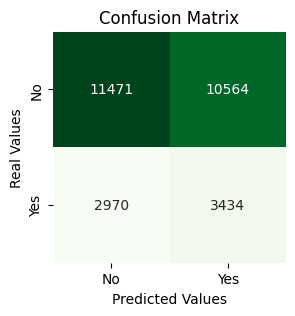

Accuracy: 0.52
Precision: 0.25
Recall: 0.54
F1 Score: 0.34


In [160]:
utils.evaluate_predictions(y1_test, y1_pred)

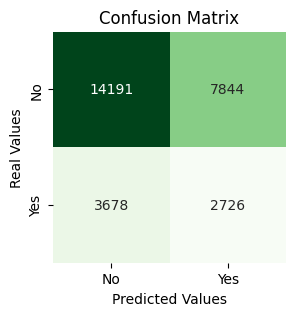

Accuracy: 0.59
Precision: 0.26
Recall: 0.43
F1 Score: 0.32


In [161]:
utils.evaluate_predictions(y2_test, y2_pred)

_Observamos que, en efecto, los resultados obtenidos con la codificación de las fechas en coordenadas polares es superior para la tarea de clasificación que estamos realizando._

##### Variable "Location"

Como evaluamos en el apartado anterior, la distancia entre estaciones meteorológicas es inversamente proporcional al coeficiente Phi para la variable RainToday. En decir, si en una estación se registra lluvia, es probable que en una estación cercana también se registre la misma condición.

Vamos a codificar la locación a partir de las coordenadas de Latitud y Longitud obtenidas mediante geolocalización con Open Street Map. De este modo informamos al modelo con la relación espacial entre las estaciones. Además, evitamos la representación dispersa que implicara utilizar one hot encoding con una variable de alta cardinalidad.

In [162]:
df = pd.merge(df, gdf_locations.drop(columns="geometry"), on="Location")

##### Variables "WindGustDir", "WindDir9am", "WindDir3pm"

Al igual que sucede con la variable de fecha, las variables relacionadas con la dirección del viento también poseen un orden circular. En el caso de estas últimas variables, incluso, necesitamos un menor grado de abstracción ya que la dirección del viento puede representarse intuitivamente como la dirección de un vector en dos dimensiones (x, y). El eje x representa la dirección Este-Oeste y el eje y representa la dirección Norte-Sur.

Esta representación vectorial nos permite incorporar la velocidad del viento como la magnitud del vector en las mismas dos variables en las que codificamos la dirección del mismo.

In [163]:
dirs = ["E", "ENE", "NE", "NNE", "N", "NNW", "NW", "WNW", "W", "WSW", "SW", "SSW", "S", "SSE", "SE", "ESE"]
angles = np.radians(np.arange(0, 360, 22.5))
mapping_dict = {d: a for (d, a) in zip(dirs, angles)}

In [164]:
wind_dir_columns = ["WindGustDir", "WindDir9am", "WindDir3pm"]
for column in wind_dir_columns:
    df[f"{column}Angle"] = df[column].map(mapping_dict)

    scaler = StandardScaler()
    scaled_speed = scaler.fit_transform(df[column.replace("Dir", "Speed")].values.reshape(-1, 1)).flatten()

    df[f"{column}Cos"] = np.cos(df[f"{column}Angle"]) * scaled_speed
    df[f"{column}Sin"] = np.sin(df[f"{column}Angle"]) * scaled_speed

    df = df.drop(columns=f"{column}Angle")

In [165]:
# Initialize lists to store results
random_states = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
polar_results = []
integer_results = []

# Methodology 1: DayCos, DaySin
df_model_cos_sin = df[["WindGustDirCos", "WindDir9amCos", "WindDir3pmCos", "WindGustDirSin", "WindDir9amSin", "WindDir3pmSin", "RainToday", "RainTomorrow"]]
df_model_cos_sin = df_model_cos_sin.dropna(how='any').reset_index(drop=True)

# Methodology 2: Day, Month
df_model_one_hot = df[["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow"]]
df_model_one_hot = df_model_one_hot.dropna(how='any').reset_index(drop=True)

df_model_one_hot = pd.get_dummies(df_model_one_hot, columns=["WindGustDir", "WindDir9am", "WindDir3pm"], drop_first=True, dtype=int)

for random_state in random_states:
    # Methodology 1: DayCos, DaySin
    X1 = df_model_cos_sin.drop(columns="RainTomorrow")
    y1 = df_model_cos_sin["RainTomorrow"]
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=random_state)

    model1 = LogisticRegression(class_weight='balanced')
    model1.fit(X1_train, y1_train)
    y1_pred = model1.predict(X1_test)

    acc1 = accuracy_score(y1_test, y1_pred)
    f1_1 = f1_score(y1_test, y1_pred)

    polar_results.append({
        'RandomState': random_state,
        'PolarAccuracy': round(acc1, 3),
        'PolarF1': round(f1_1, 3)
    })

    # Methodology 2: Day, Month
    X2 = df_model_one_hot.drop(columns="RainTomorrow")
    y2 = df_model_one_hot["RainTomorrow"]
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=random_state)

    scaler = StandardScaler()
    X2_train_scaled = scaler.fit_transform(X2_train)
    X2_test_scaled = scaler.transform(X2_test)

    model2 = LogisticRegression(class_weight='balanced')
    model2.fit(X2_train_scaled, y2_train)
    y2_pred = model2.predict(X2_test_scaled)

    acc2 = accuracy_score(y2_test, y2_pred)
    f1_2 = f1_score(y2_test, y2_pred)

    integer_results.append({
        'RandomState': random_state,
        'IntegerAccuracy': round(acc2, 3),
        'IntegerF1': round(f1_2, 3)
    })

# Create DataFrames from results
polar_df = pd.DataFrame(polar_results)
integer_df = pd.DataFrame(integer_results)

# Merge the DataFrames on 'RandomState'
comparison_df = pd.merge(polar_df, integer_df, on='RandomState')

# Display the comparison DataFrame
comparison_df

,RandomState,PolarAccuracy,PolarF1,IntegerAccuracy,IntegerF1
0,10,0.759,0.473,0.723,0.502
1,20,0.760,0.477,0.724,0.507
2,30,0.759,0.484,0.725,0.512
3,40,0.760,0.474,0.725,0.510
4,50,0.761,0.486,0.723,0.509
5,60,0.760,0.475,0.723,0.502
6,70,0.757,0.477,0.723,0.510
7,80,0.758,0.476,0.722,0.507
8,90,0.757,0.478,0.721,0.505
9,100,0.762,0.487,0.731,0.521


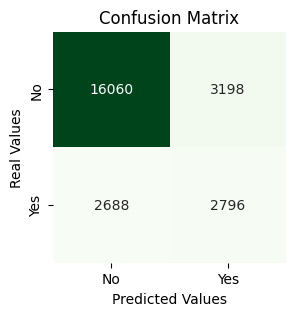

Accuracy: 0.76
Precision: 0.47
Recall: 0.51
F1 Score: 0.49


In [166]:
utils.evaluate_predictions(y1_test, y1_pred)

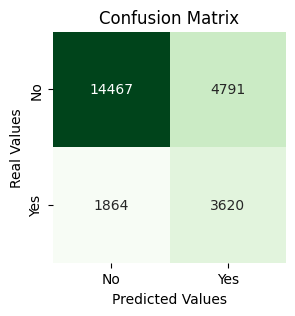

Accuracy: 0.73
Precision: 0.43
Recall: 0.66
F1 Score: 0.52


In [167]:
utils.evaluate_predictions(y2_test, y2_pred)